## Per User/Session, what is the distribution of interclick times? Moreover, can we model the behavior of the user as a poisson process?

In [120]:
# imports
import pandas as pd
import pyexasol

pd.set_option("display.max_colwidth", None)
def printQuery(query, connection):
    stmt = connection.export_to_pandas(query)
    print(stmt.head())
    return stmt

host = '192.168.56.101/8A3F422F336963EBB2E452E08A6B6E7060A554D85223032A44E9C60F0EFB8544:8563'  # Don't forget to change the fingerprint
user = 'sys'
password = 'exasol'

# Connect to Exasol
conn = pyexasol.connect(dsn=host, 
                        user=user, 
                        password=password, 
                        debug=False, 
                        protocol_version=pyexasol.PROTOCOL_V1)

In [ ]:
# Get top 20 url queries, user, and time data
q = '''
SELECT 
    QUERYDIM.QUERY, 
    TIMEDIM.[month], 
    TIMEDIM.[day of the month], 
    TIMEDIM.[day of the year], 
    TIMEDIM.[hour], 
    TIMEDIM.[minute], 
    TIMEDIM.[second], 
    CASE 
        WHEN TIMEDIM.[day of the year] BETWEEN 60 AND 90 THEN '03'
        WHEN TIMEDIM.[day of the year] BETWEEN 91 AND 120 THEN '04'
        WHEN TIMEDIM.[day of the year] BETWEEN 121 AND 151 THEN '05'
    END AS numeric_month, 
    FACTS.ANONID,
        CAST(
        CONCAT(
            '2006-', -- Example: Use a static year or use TIMEDIM.YEAR if available
            LPAD(CASE 
                WHEN TIMEDIM.[day of the year] BETWEEN 60 AND 90 THEN '03'
                WHEN TIMEDIM.[day of the year] BETWEEN 91 AND 120 THEN '04'
                WHEN TIMEDIM.[day of the year] BETWEEN 121 AND 151 THEN '05'
                END, 2, '0'), '-', 
            LPAD(TIMEDIM.[day of the month], 2, '0'), ' ',
            LPAD(TIMEDIM.[hour], 2, '0'), ':', 
            LPAD(TIMEDIM.[minute], 2, '0'), ':', 
            LPAD(TIMEDIM.[second], 2, '0')
        ) AS TIMESTAMP) AS time_as_datetime
FROM AOL_SCHEMA.QUERYDIM 
    LEFT JOIN AOL_SCHEMA.FACTS ON QUERYDIM.ID = FACTS.QUERYID
    LEFT JOIN AOL_SCHEMA.TIMEDIM ON FACTS.TIMEID = TIMEDIM.ID
    LEFT JOIN AOL_SCHEMA.URLDIM ON FACTS.URLID = URLDIM.ID
WHERE FACTS.CLICK = 1
    AND QUERYDIM.QUERY IS NOT NULL
    AND URLDIM.URL IN (
        SELECT URLDIM.URL
        FROM AOL_SCHEMA.FACTS 
        JOIN AOL_SCHEMA.URLDIM ON AOL_SCHEMA.FACTS.URLID = AOL_SCHEMA.URLDIM.ID
        WHERE AOL_SCHEMA.FACTS.CLICK = 1
        GROUP BY URLDIM.URL
        ORDER BY COUNT(AOL_SCHEMA.FACTS.CLICK) DESC
        LIMIT 20
    )
    AND FACTS.ANONID IS NOT NULL
    AND TIMEDIM.[hour] IS NOT NULL
    AND TIMEDIM.[minute] IS NOT NULL
    AND TIMEDIM.[second] IS NOT NULL
    AND TIMEDIM.[month] IS NOT NULL
    AND TIMEDIM.[day of the year] IS NOT NULL
GROUP BY QUERYDIM.QUERY, 
         TIMEDIM.[month], 
         TIMEDIM.[day of the month], 
         TIMEDIM.[day of the year], 
         TIMEDIM.[hour], 
         TIMEDIM.[minute], 
         TIMEDIM.[second], 
         FACTS.ANONID,
         FACTS.TIMEID
ORDER BY TIMEDIM.[day of the year], 
         TIMEDIM.[hour], 
         TIMEDIM.[minute], 
         TIMEDIM.[second];
'''

# Interarrival time table with properly formatted date/time
q =  '''
CREATE TABLE AOL_SCHEMA.INTERARRIVAL_TIMES AS
    SELECT 
        FACTS.ANONID,
        CAST(
        CONCAT(
            '2006-', -- Example: Use a static year or use TIMEDIM.YEAR if available
            LPAD(CASE 
                WHEN TIMEDIM.[day of the year] BETWEEN 60 AND 90 THEN '03'
                WHEN TIMEDIM.[day of the year] BETWEEN 91 AND 120 THEN '04'
                WHEN TIMEDIM.[day of the year] BETWEEN 121 AND 151 THEN '05'
                ELSE '01'
            END, 2, '0'), '-', 
            LPAD(TIMEDIM.[day of the month], 2, '0'), ' ',
            LPAD(TIMEDIM.[hour], 2, '0'), ':', 
            LPAD(TIMEDIM.[minute], 2, '0'), ':', 
            LPAD(TIMEDIM.[second], 2, '0')
        ) AS TIMESTAMP) AS time_as_datetime
    FROM
        AOL_SCHEMA.FACTS LEFT JOIN AOL_SCHEMA.TIMEDIM ON FACTS.TIMEID = TIMEDIM.ID
        LEFT JOIN AOL_SCHEMA.URLDIM ON FACTS.URLID = URLDIM.ID
    WHERE FACTS.CLICK = 1
        AND URLDIM.URL IN (
            SELECT URLDIM.URL
            FROM AOL_SCHEMA.FACTS 
            JOIN AOL_SCHEMA.URLDIM ON AOL_SCHEMA.FACTS.URLID = AOL_SCHEMA.URLDIM.ID
            WHERE AOL_SCHEMA.FACTS.CLICK = 1
            GROUP BY URLDIM.URL
            ORDER BY COUNT(AOL_SCHEMA.FACTS.CLICK) DESC
            LIMIT 20
        )
        AND FACTS.ANONID IS NOT NULL
        AND TIMEDIM.[hour] IS NOT NULL
        AND TIMEDIM.[minute] IS NOT NULL
        AND TIMEDIM.[second] IS NOT NULL
        AND TIMEDIM.[day of the year] IS NOT NULL
'''
conn.execute("DROP TABLE AOL_SCHEMA.INTERARRIVAL_TIMES")
conn.execute(q)




#df = printQuery(q, conn)


<ExaStatement session_id=1814580739466814138 stmt_idx=2>

In [ ]:
# Obtain the anon ID's and times where there are more than 100 instances of clicking on a webpage in the top 20 most clicked webpages

q = '''
SELECT 
    T1.ANONID,
    T1.TIME_AS_DATETIME,
    COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME) AS LaggedDateTime,
    SECONDS_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Seconds_Difference,
    MINUTES_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Minutes_Difference,
    HOURS_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Hours_Difference,
    DAYS_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Days_Difference,
    MONTHS_BETWEEN(T1.TIME_AS_DATETIME, COALESCE(LAG(TIME_AS_DATETIME) OVER (PARTITION BY ANONID ORDER BY TIME_AS_DATETIME), TIME_AS_DATETIME)) as Months_Difference
FROM AOL_SCHEMA.INTERARRIVAL_TIMES as T1
WHERE T1.ANONID IN (
    SELECT T2.ANONID
    FROM AOL_SCHEMA.INTERARRIVAL_TIMES as T2
    GROUP BY T2.ANONID
    HAVING COUNT(T2.ANONID) >= 100
)

ORDER BY
    T1.ANONID,
    T1.TIME_AS_DATETIME
'''

df = printQuery(q, conn)

   ANONID            TIME_AS_DATETIME              LAGGEDDATETIME  \
0   42833  2006-03-19 15:48:52.000000  2006-03-19 15:48:52.000000   
1   42833  2006-03-19 16:07:07.000000  2006-03-19 15:48:52.000000   
2   42833  2006-03-21 14:29:30.000000  2006-03-19 16:07:07.000000   
3   42833  2006-03-21 14:36:31.000000  2006-03-21 14:29:30.000000   
4   42833  2006-03-21 14:36:31.000000  2006-03-21 14:36:31.000000   

   SECONDS_DIFFERENCE  MINUTES_DIFFERENCE  HOURS_DIFFERENCE  DAYS_DIFFERENCE  \
0                   0            0.000000          0.000000                0   
1                1095           18.250000          0.304167                0   
2              166943         2782.383333         46.373056                2   
3                 421            7.016667          0.116944                0   
4                   0            0.000000          0.000000                0   

   MONTHS_DIFFERENCE  
0           0.000000  
1           0.000000  
2           0.064516  
3           

In [126]:
df.shape
df

,ANONID,TIME_AS_DATETIME,LAGGEDDATETIME,SECONDS_DIFFERENCE,MINUTES_DIFFERENCE,HOURS_DIFFERENCE,DAYS_DIFFERENCE,MONTHS_DIFFERENCE
0,42833,2006-03-19 15:48:52.000000,2006-03-19 15:48:52.000000,0,0.000000,0.000000,0,0.000000
1,42833,2006-03-19 16:07:07.000000,2006-03-19 15:48:52.000000,1095,18.250000,0.304167,0,0.000000
2,42833,2006-03-21 14:29:30.000000,2006-03-19 16:07:07.000000,166943,2782.383333,46.373056,2,0.064516
3,42833,2006-03-21 14:36:31.000000,2006-03-21 14:29:30.000000,421,7.016667,0.116944,0,0.000000
4,42833,2006-03-21 14:36:31.000000,2006-03-21 14:36:31.000000,0,0.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...
13089,476982,2006-04-10 00:02:47.000000,2006-04-10 00:02:40.000000,7,0.116667,0.001944,0,0.000000
13090,476982,2006-04-10 00:03:04.000000,2006-04-10 00:02:47.000000,17,0.283333,0.004722,0,0.000000
13091,476982,2006-04-10 00:03:44.000000,2006-04-10 00:03:04.000000,40,0.666667,0.011111,0,0.000000
13092,476982,2006-04-10 00:05:02.000000,2006-04-10 00:03:44.000000,78,1.300000,0.021667,0,0.000000


#### Check histograms per user

(array([955.,  48.,  43.,   9.,   9.,   2.,   0.,   1.,   0.,   3.]),
 array([     0. ,  16694.3,  33388.6,  50082.9,  66777.2,  83471.5,
        100165.8, 116860.1, 133554.4, 150248.7, 166943. ]),
 <BarContainer object of 10 artists>)

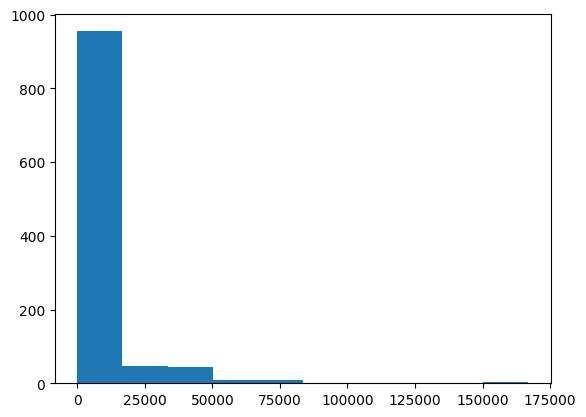

In [128]:
import matplotlib.pyplot as plt

plt.hist(df[df['ANONID'] == 42833]['SECONDS_DIFFERENCE'])

#### Do a test of distribution (exponential) for seconds difference for each user. Look at proportion of users who follow the exponential distribution.

#### Find a nice example graph